In [1]:
import os
import sys
sparclur_path = os.path.abspath('/Users/sdavis/PycharmProjects/sparclur/')
if sparclur_path not in sys.path:
    sys.path.append(sparclur_path)
from sparclur import Spotlight
from sparclur.parsers import *

### Load the Hello World pdf

In [2]:
hello_world = os.path.join(sparclur_path, 'resources', 'hello_world_hand_edit.pdf')

### Set the parsers to run with Spotlight

In [3]:
parsers = ['Poppler', 'MuPDF', 'PDFCPU', 'Ghostscript', 'XPDF', 'PDFMiner', 'QPDF']

### Instantiate Spotlight and generate the result

In [4]:
spotlight = Spotlight(num_workers=5, parsers=parsers)
spotlight_result = spotlight.run(hello_world)

 14%|█▍        | 4/28 [00:01<00:25,  1.08s/it]mupdf: expected generation number (0 ? obj)
mupdf: expected generation number (0 ? obj)
100%|██████████| 7/7 [00:00<00:00, 39729.54it/s]


<hr>

### Display the report for the validity of the original file and all of the cleaned-up versions for each parser run through Spotlight

In [5]:
spotlight_result.validity_report()

,original,Ghostscript,MuPDF,Poppler
PDFCPU,Valid,Valid,Valid,Valid
MuPDF,Rejected,Valid,Valid,Valid
PDFMiner,Valid,Valid,Valid,Valid
Ghostscript,Valid,Valid,Valid,Valid
QPDF,Valid with Warnings,Valid,Valid,Valid
XPDF,Rejected,Valid,Valid,Valid
Poppler,Rejected,Valid,Rejected,Valid
Overall,Rejected,Valid,Rejected,Valid


<hr>

### Since Poppler rejects the cleaned-up version generated by MuPDF, the file's recovery is ambiguous. This can be seen in the call below.

In [6]:
print(spotlight_result.recoverable())

Recovery ambigous:
	MuPDF: Rejected


<hr>

### Let's see why Poppler rejected the file in the first place. All tools came back valid except font extraction.

In [7]:
poppler = Poppler(hello_world)
poppler.validity

{'Tracer': {'valid': True, 'status': 'Valid'},
 'Text Extractor': {'valid': True, 'status': 'Valid'},
 'Renderer': {'valid': True, 'status': 'Valid'},
 'Font Extractor': {'valid': False,
  'status': 'Rejected',
  'info': 'Errors returned'},
 'Image Data': {'valid': True, 'status': 'Valid'},
 'overall': {'valid': False, 'status': 'Rejected'}}

<hr>

### Here's the extracted font:

In [8]:
poppler.fonts

[{'name': 'Times-Roman',
  'type': 'Type 1',
  'encoding': 'Standard',
  'emb': False,
  'sub': False,
  'uni': False,
  'object ID': '[none] R'}]

<hr>

### Let's clean up the file using Poppler and see what happens to the font:

In [9]:
poppler_cleanup = poppler.reforge
cleaned_poppler = Poppler(poppler_cleanup)
cleaned_poppler.validity

{'Tracer': {'valid': True, 'status': 'Valid'},
 'Text Extractor': {'valid': True, 'status': 'Valid'},
 'Renderer': {'valid': True, 'status': 'Valid'},
 'Font Extractor': {'valid': True, 'status': 'Valid'},
 'Image Data': {'valid': True, 'status': 'Valid'},
 'overall': {'valid': True, 'status': 'Valid'}}

In [10]:
cleaned_poppler.fonts

[{'name': 'QELDOZ+Times-Roman',
  'type': 'TrueType',
  'encoding': 'WinAnsi',
  'emb': True,
  'sub': True,
  'uni': True,
  'object ID': '6  0 R'}]

<hr>

### Poppler embedded a system font into the cleaned up version. Now let's see what the MuPDF reforged document does for the font extraction:

In [11]:
mupdf_cleanup = MuPDF(hello_world).reforge
mu_poppler = Poppler(mupdf_cleanup)
mu_poppler.validity

{'Tracer': {'valid': True, 'status': 'Valid'},
 'Text Extractor': {'valid': True, 'status': 'Valid'},
 'Renderer': {'valid': True, 'status': 'Valid'},
 'Font Extractor': {'valid': False,
  'status': 'Rejected',
  'info': 'Errors returned'},
 'Image Data': {'valid': True, 'status': 'Valid'},
 'overall': {'valid': False, 'status': 'Rejected'}}

<hr>

### We can see that the MuPDF cleaning process left the font information untouched, which is why Poppler marked this version invalid.

In [12]:
mu_poppler.fonts

[{'name': 'Times-Roman',
  'type': 'Type 1',
  'encoding': 'Standard',
  'emb': False,
  'sub': False,
  'uni': False,
  'object ID': '[none] R'}]

<hr>

### Spotlight also allows us to quickly explore the similarity between each of the reforged versions over each of the parsers. This similarity score is an average of the signatures derived from text extraction, rendering, and trace messages. So a high similarity score means that the reforging process produced the same text, rendering, and messages for each parser.

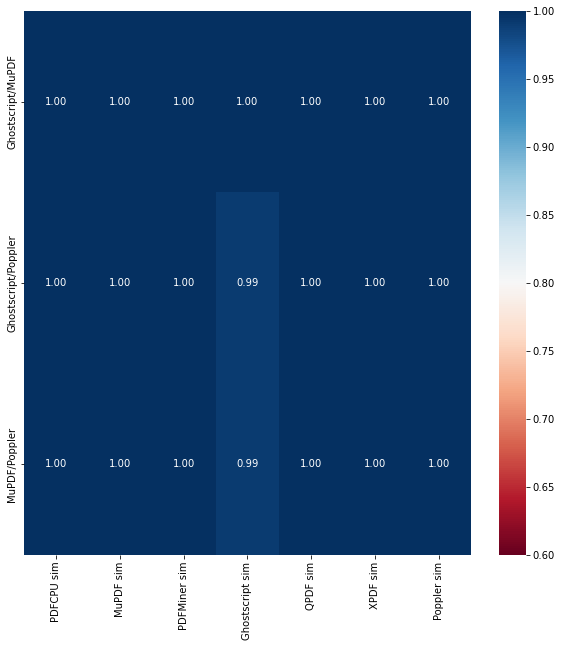

In [13]:
spotlight_result.sim_heatmap(report='sim', compare_orig=False)